Compiling code

1.   Object detection in Video
2.   Eye blink detection
3.   Face recognition



Mounting google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
path = '/content/drive/MyDrive/Colab Notebooks/ND Face Recognition/compiled'
os.chdir(path)

Mounted at /content/drive


Importing the required libraries

In [3]:
!pip install ultralytics
!pip install deepface
!pip install "/content/drive/MyDrive/Colab Notebooks/ND Face Recognition/compiled/Dependencies/dlib-19.24.1-cp311-cp311-win_amd64.whl"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 9.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [4]:
import numpy as np
import pandas as pd

import cv2
from google.colab.patches import cv2_imshow
from ultralytics import YOLO

import dlib
from imutils import face_utils
from scipy.spatial import distance as dist

In [20]:
#1. Loading the pre-trained model for yolov8m
import time

tic = time.time()

model = YOLO('yolov8m.pt')

# 1. Reading the video
vid = cv2.VideoCapture('/content/drive/MyDrive/Colab Notebooks/ND Face Recognition/compiled/inputs/Ashish.mp4')

# 2. Running the video
results = model(source= '/content/drive/MyDrive/Colab Notebooks/ND Face Recognition/compiled/inputs/Ashish.mp4', show = True,
                conf = 0.4, save = True)


# 3. Initialize an empty set to store unique object names
detected_objects = set()

for result in results:
       for detection in result.boxes:
        class_id = int(detection.cls)
        class_name = model.names[class_id]
        detected_objects.add(class_name)

# 4. Convert the set to a list to get the final list of detected objects
objects_list = list(detected_objects)
print(objects_list)
print('\n')

# 5. Detected objects
objects_of_interest = ["cell phone"]
# objects_of_interest = ["cell phone", "laptop"]
if any(obj in objects_list for obj in objects_of_interest):
    print("UNAUTHORISED ACCESS: Phone/Laptop is detected.")
else:
   print('Moving to eye-blink detection.')
   print('\n')

   import dlib
   from imutils import face_utils
   import numpy as np
   from scipy.spatial import distance as dist

   def eye_aspect_ratio(eye):
       A = dist.euclidean(eye[1], eye[5])
       B = dist.euclidean(eye[2], eye[4])
       C = dist.euclidean(eye[0], eye[3])
       ear = (A + B) / (2.0 * C)
       return ear

   EYE_AR_THRESH = 0.21
   EYE_AR_CONSEC_FRAMES = 5

   # Initialize counters
   COUNTER = 0
   TOTAL = 0

   # Initialize dlib's face detector and create the facial landmark predictor
   detector = dlib.get_frontal_face_detector()
   predictor = dlib.shape_predictor('/content/drive/MyDrive/Colab Notebooks/ND Face Recognition/compiled/Dependencies/shape_predictor_68_face_landmarks.dat')

   (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
   (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

   # Reading video file
   #  video_path = '/content/drive/MyDrive/Colab Notebooks/ND Face Recognition/Eye Blink Detection/clips/Fadnavis.mp4'
   cap = vid

   # Get the width and height of the frames in the video
   frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
   frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

   # Define the codec and create VideoWriter object
   output_path = '/content/drive/MyDrive/Colab Notebooks/ND Face Recognition/compiled/outputs/output - Fadnavis.avi'
   out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), 10, (frame_width, frame_height))

   while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
      break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 0)

    for rect in rects:
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        leftEye = shape[lStart:lEnd]
        rightEye = shape[rStart:rEnd]
        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)

        ear = (leftEAR + rightEAR) / 2.0

        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

        if ear < EYE_AR_THRESH:
            COUNTER += 1
        else:
            if COUNTER >= EYE_AR_CONSEC_FRAMES:
                TOTAL += 1
            COUNTER = 0

        cv2.putText(frame, "Blinks: {}".format(TOTAL), (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # Write the frame to the output video file
    out.write(frame)

    # cv2_imshow(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

   cap.release()
   out.release()
   cv2.destroyAllWindows()

   # Print the final number of blinks
   print(f"Total number of blinks detected: {TOTAL}")


   if not TOTAL:
    print('UNAUTHOURIZED ACCESS: Spoofing detected')
   else:
     print('Moving to face detection.')

     # 4. Initialize variables to store the highest scoring person object and its corresponding frame
     highest_score = 0
     person_bbox_with_highest_score = None
     frame_with_highest_score = None

     # Open the video file
     cap = cv2.VideoCapture('/content/drive/MyDrive/Colab Notebooks/ND Face Recognition/compiled/inputs/Ashish.mp4')

     # Iterate over the detected frames
     for frame_idx, frame_results in enumerate(results):
      for detection in frame_results.boxes.data:
        x1, y1, x2, y2, conf, cls = detection

        # Check if the detected object is a person (assuming class '0' corresponds to 'person')
        if int(cls) == 0 and conf > highest_score:
            highest_score = conf
            person_bbox_with_highest_score = (int(x1), int(y1), int(x2), int(y2))

            # Set the video frame to the current frame index
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame_with_highest_score = cap.read()

        cap.release()

        # If a person object with the highest score is found, crop the corresponding region from the frame
        if person_bbox_with_highest_score is not None:
          x1, y1, x2, y2 = person_bbox_with_highest_score
          cropped_person = frame_with_highest_score[y1:y2, x1:x2]
          # Display or save the cropped person image
          print(f'Frame no. {frame_idx}: {highest_score}')
          # cv2_imshow(cropped_person)
          cv2.waitKey(0)
          cv2.destroyAllWindows()




toc = time.time()
print(f'Total time required for code running: {toc-tic}')


TypeError: 'NoneType' object is not subscriptable

In [21]:
ret

False

In [24]:
import numpy as np
import pandas as pd

import cv2
from google.colab.patches import cv2_imshow
from ultralytics import YOLO

import dlib
from imutils import face_utils
from scipy.spatial import distance as dist

import time

# Start timer
tic = time.time()

# Load the pre-trained model for YOLOv8
model = YOLO('yolov8m.pt')

# Path to the video
video_path = '/content/drive/MyDrive/Colab Notebooks/ND Face Recognition/compiled/inputs/Ashish.mp4'

# Run the video through the model
results = model(source=video_path, show=True, conf=0.4, save=True)

# Initialize an empty set to store unique object names
detected_objects = set()

# Process the results
for result in results:
    for detection in result.boxes.data:
        class_id = int(detection[5])
        class_name = model.names[class_id]
        detected_objects.add(class_name)

# Convert the set to a list to get the final list of detected objects
objects_list = list(detected_objects)
print(objects_list)
print('\n')

# Check for unauthorized objects
objects_of_interest = ["cell phone"]
if any(obj in objects_list for obj in objects_of_interest):
    print("UNAUTHORISED ACCESS: Phone/Laptop is detected.")
else:
    print('Moving to eye-blink detection.\n')

    def eye_aspect_ratio(eye):
        A = dist.euclidean(eye[1], eye[5])
        B = dist.euclidean(eye[2], eye[4])
        C = dist.euclidean(eye[0], eye[3])
        ear = (A + B) / (2.0 * C)
        return ear

    EYE_AR_THRESH = 0.21
    EYE_AR_CONSEC_FRAMES = 5

    # Initialize counters
    COUNTER = 0
    TOTAL = 0

    # Initialize dlib's face detector and create the facial landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('/content/drive/MyDrive/Colab Notebooks/ND Face Recognition/compiled/Dependencies/shape_predictor_68_face_landmarks.dat')

    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

    # Open the video file again for eye blink detection
    cap = cv2.VideoCapture(video_path)

    # Get the width and height of the frames in the video
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create VideoWriter object
    output_path = '/content/drive/MyDrive/Colab Notebooks/ND Face Recognition/compiled/outputs/output - Fadnavis.avi'
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), 10, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)

        for rect in rects:
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)

            leftEye = shape[lStart:lEnd]
            rightEye = shape[rStart:rEnd]
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)

            ear = (leftEAR + rightEAR) / 2.0

            leftEyeHull = cv2.convexHull(leftEye)
            rightEyeHull = cv2.convexHull(rightEye)
            cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
            cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

            if ear < EYE_AR_THRESH:
                COUNTER += 1
            else:
                if COUNTER >= EYE_AR_CONSEC_FRAMES:
                    TOTAL += 1
                COUNTER = 0

            cv2.putText(frame, "Blinks: {}".format(TOTAL), (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # Write the frame to the output video file
        out.write(frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

    # Print the final number of blinks
    print(f"Total number of blinks detected: {TOTAL}")

    if not TOTAL:
        print('UNAUTHORISED ACCESS: Spoofing detected')
    else:
        print('Moving to face detection.')

        # Initialize variables to store the highest scoring person object and its corresponding frame
        highest_score = 0
        person_bbox_with_highest_score = None
        frame_with_highest_score = None

        # Open the video file again for face detection
        cap = cv2.VideoCapture(video_path)

        # Iterate over the detected frames
        for frame_idx, frame_results in enumerate(results):
            for detection in frame_results.boxes.data:
                x1, y1, x2, y2, conf, cls = detection

                # Check if the detected object is a person (assuming class '0' corresponds to 'person')
                if int(cls) == 0 and conf > highest_score:
                    highest_score = conf
                    person_bbox_with_highest_score = (int(x1), int(y1), int(x2), int(y2))

                    # Set the video frame to the current frame index
                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                    ret, frame_with_highest_score = cap.read()

        cap.release()

        # If a person object with the highest score is found, crop the corresponding region from the frame
        if person_bbox_with_highest_score is not None and frame_with_highest_score is not None:
            x1, y1, x2, y2 = person_bbox_with_highest_score
            cropped_person = frame_with_highest_score[y1:y2, x1:x2]
            # Display or save the cropped person image
            print(f'Frame no. {frame_idx}: {highest_score}')
            # cv2_imshow(cropped_person)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

toc = time.time()
print(f'Total time required for code running: {toc-tic}')


WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/91) /content/drive/MyDrive/Colab Notebooks/ND Face Recognition/compiled/inputs/Ashish.mp4: 640x480 1 person, 1 bottle, 1 chair, 1 laptop, 2 keyboards, 1125.5ms
video 1/1 (frame 2/91) /content/drive/MyDrive/Colab Notebooks/ND Face Recognition/compiled/inputs/Ashish.mp4: 640x480 1 person, 1 bottle, 2 keyboards, 1099.1ms
video 1/1 (frame 3/91) /content/drive/MyDri

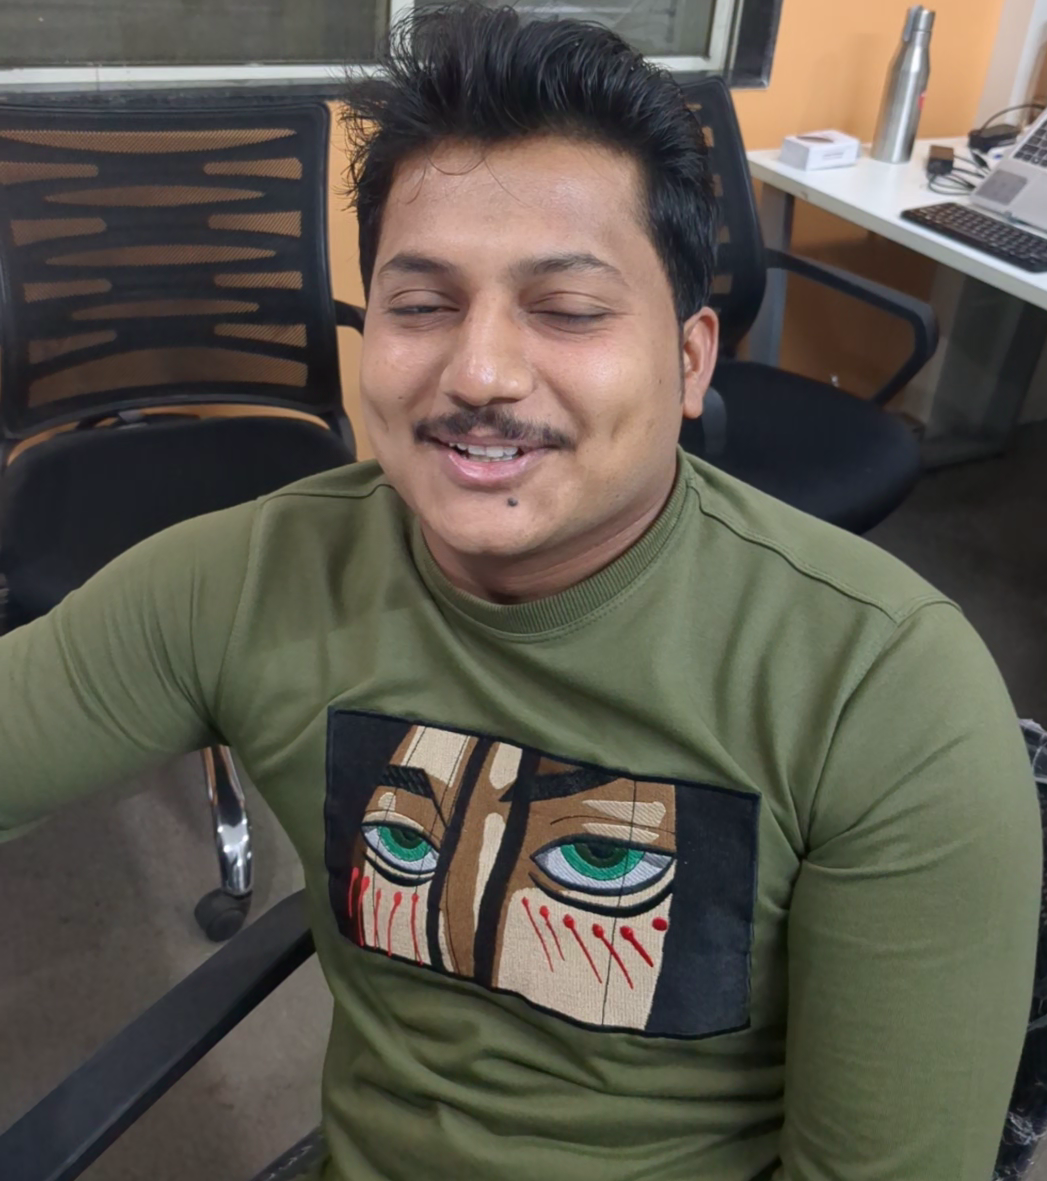

In [26]:
cv2_imshow(cropped_person)

In [31]:

from deepface import DeepFace

# Path to the database directory
db_path = "/content/drive/MyDrive/Colab Notebooks/ND Face Recognition/Faces/train/AshishGhule"


# Perform facial recognition
result = DeepFace.find(cropped_person, db_path, enforce_detection=True)
result

24-06-05 15:14:34 - Found 0 newly added image(s), 0 removed image(s), 10 replaced image(s).


Finding representations:  60%|██████    | 6/10 [00:09<00:05,  1.30s/it]

24-06-05 15:14:44 - 🔴 Exception while extracting faces from /content/drive/MyDrive/Colab Notebooks/ND Face Recognition/Faces/train/AshishGhule/7.jpeg: Face could not be detected in /content/drive/MyDrive/Colab Notebooks/ND Face Recognition/Faces/train/AshishGhule/7.jpeg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Finding representations: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


24-06-05 15:14:46 - 🔴 Exception while extracting faces from /content/drive/MyDrive/Colab Notebooks/ND Face Recognition/Faces/train/AshishGhule/5.jpeg: Face could not be detected in /content/drive/MyDrive/Colab Notebooks/ND Face Recognition/Faces/train/AshishGhule/5.jpeg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
24-06-05 15:14:46 - There are now 12 representations in ds_model_vggface_detector_opencv_aligned_normalization_base_expand_0.pkl
24-06-05 15:14:46 - Searching [[[ 95  99  99]
  [ 95  99  99]
  [ 94  98  98]
  ...
  [213 206 201]
  [213 206 201]
  [212 205 205]]

 [[ 93  97  97]
  [ 93  97  97]
  [ 92  96  96]
  ...
  [213 206 201]
  [213 206 201]
  [211 204 204]]

 [[ 91  95  95]
  [ 91  95  95]
  [ 91  95  95]
  ...
  [213 206 201]
  [213 206 201]
  [213 204 204]]

 ...

 [[ 51  40  36]
  [ 51  40  36]
  [ 52  41  37]
  ...
  [103 108 111]
  [103 108 111]
  [103 108 111]]

 [[ 51  40  36]
  [ 51  40  36]
  [ 51  40  36]

[                                            identity  \
 0  /content/drive/MyDrive/Colab Notebooks/ND Face...   
 1  /content/drive/MyDrive/Colab Notebooks/ND Face...   
 2  /content/drive/MyDrive/Colab Notebooks/ND Face...   
 3  /content/drive/MyDrive/Colab Notebooks/ND Face...   
 4  /content/drive/MyDrive/Colab Notebooks/ND Face...   
 5  /content/drive/MyDrive/Colab Notebooks/ND Face...   
 
                                        hash  target_x  target_y  target_w  \
 0  6bf88619101aecc72d2d47e8fdd387ce9a22b960       135        86       186   
 1  4490fa7f2e3fbeaf803a72634c345ce37814ff80       152        80       130   
 2  43957b5f863d8ec2a347073f4f4382a9aaab5599       227       162       408   
 3  21f30d1c44f7c90fe127b55effe36df7b6fc1a59        52        42       113   
 4  a168146803f6ad66a6be3c7bea1c30691f18ddba       202        55       161   
 5  4895726068bfb8140d30bb7aa1db833e167ee2e8       202        55       161   
 
    target_h  source_x  source_y  source_w  source_

In [33]:
result[0]

,identity,hash,target_x,target_y,target_w,target_h,source_x,source_y,source_w,source_h,threshold,distance
0,/content/drive/MyDrive/Colab Notebooks/ND Face...,6bf88619101aecc72d2d47e8fdd387ce9a22b960,135,86,186,186,287,140,419,419,0.68,0.302902
1,/content/drive/MyDrive/Colab Notebooks/ND Face...,4490fa7f2e3fbeaf803a72634c345ce37814ff80,152,80,130,130,287,140,419,419,0.68,0.379887
2,/content/drive/MyDrive/Colab Notebooks/ND Face...,43957b5f863d8ec2a347073f4f4382a9aaab5599,227,162,408,408,287,140,419,419,0.68,0.446000
3,/content/drive/MyDrive/Colab Notebooks/ND Face...,21f30d1c44f7c90fe127b55effe36df7b6fc1a59,52,42,113,113,287,140,419,419,0.68,0.605279
4,/content/drive/MyDrive/Colab Notebooks/ND Face...,a168146803f6ad66a6be3c7bea1c30691f18ddba,202,55,161,161,287,140,419,419,0.68,0.622856
5,/content/drive/MyDrive/Colab Notebooks/ND Face...,4895726068bfb8140d30bb7aa1db833e167ee2e8,202,55,161,161,287,140,419,419,0.68,0.622856
